In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from functools import partial

import catboost as cb
from sklearn import preprocessing
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# custom modules
from preproc import load_data
#from calibration1 import calibrate_probs,optimize_calibration
from calibration2 import calibrate_probs,optimize_calibration

***
## loading data

In [2]:
train,test,input_cols = load_data()

display(train)
display(test)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))
# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true, eps=1e-15):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
model_params = {
    'grow_policy': 'SymmetricTree',
    'learning_rate': 0.01,
    'random_seed': 2112,
    'verbose': 0,
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 8.106235785558402,
    'depth': 3,
    'iterations': 2834,
    'l2_leaf_reg': 4.938492297826001,
    'min_data_in_leaf': 77,
    'random_strength': 6.402366066194843,
    'rsm': 0.95,
    'sampling_frequency': 'PerTree',
    'scale_pos_weight': 4.712962962962963
}

In [7]:
VERBOSE = False

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)

        model = cb.CatBoostClassifier(**model_params)
        model.fit(
            train_df.loc[:,input_cols],
            train_df.loc[:,"Class"].values
        )
        
        y_pred = model.predict(
            valid_df.loc[:,input_cols], 
            prediction_type="Probability"
        )
        valid_loss = balanced_logloss_(y_pred[:,1], valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred[:,1]
        
        models.append(model)
        metrics.append(valid_loss)
        
    oof_dfs.append(oof)

REPEAT NUMBER: 1/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 2/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 3/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 4/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 5/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 6/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUM

***
## OOF analysis and calibration

In [8]:
oof_scores = oof_dfs[0].copy()
oof_scores.rename({"pred_proba":"pred_proba0"}, axis=1, inplace=True)

for i in range(1, len(oof_dfs)):
    _df = oof_dfs[i].copy()
    _df.rename({"pred_proba":f"pred_proba{i}"}, axis=1, inplace=True)
    oof_scores = oof_scores.merge(_df, on=["Id","Class"])
    
oof_scores["avg_proba"] = oof_scores.iloc[:,2:].mean(axis=1)
oof_scores

,Id,Class,pred_proba0,pred_proba1,pred_proba2,pred_proba3,pred_proba4,pred_proba5,pred_proba6,pred_proba7,pred_proba8,pred_proba9,avg_proba
0,000ff2bfdfe9,1,0.886134,0.922426,0.910582,0.911613,0.925351,0.928837,0.894524,0.918486,0.967083,0.926908,0.919194
1,007255e47698,0,0.009959,0.007271,0.012999,0.012717,0.010001,0.009508,0.014141,0.008634,0.017268,0.013051,0.011555
2,013f2bd269f5,0,0.195130,0.244445,0.156990,0.232839,0.166592,0.219037,0.224794,0.164440,0.199194,0.126258,0.192972
3,043ac50845d5,0,0.180028,0.098262,0.066336,0.137507,0.091526,0.123327,0.096423,0.118392,0.106993,0.095964,0.111476
4,044fb8a146ec,1,0.530663,0.637618,0.598943,0.648035,0.465946,0.527024,0.586100,0.664443,0.484128,0.614145,0.575704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0,0.043171,0.045414,0.071671,0.030060,0.037265,0.041748,0.040063,0.033510,0.053822,0.023892,0.042062
613,fd895603f071,0,0.177852,0.145648,0.224883,0.143456,0.183025,0.103913,0.100763,0.128937,0.113767,0.157476,0.147972
614,fd8ef6377f76,0,0.032152,0.040712,0.013173,0.026281,0.024527,0.036937,0.031236,0.028778,0.033170,0.024339,0.029130
615,fe1942975e40,0,0.052898,0.033875,0.049492,0.074126,0.034935,0.035690,0.052256,0.045218,0.040861,0.053927,0.047328


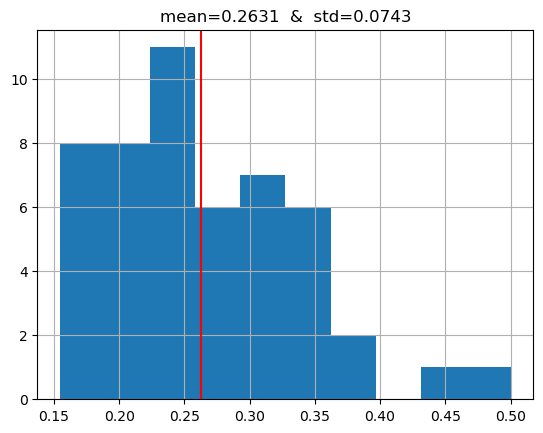

In [9]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

In [10]:
calib_params = optimize_calibration(oof_dfs)

best_value: 0.22835158860669114
best_params: {'alpha': 2.9879910652183757, 'beta': 4.595661956467351, 'gamma': 0.7549655758542108}


####################################################################################################
CV repeat nbr: 1 - metric: 0.2612


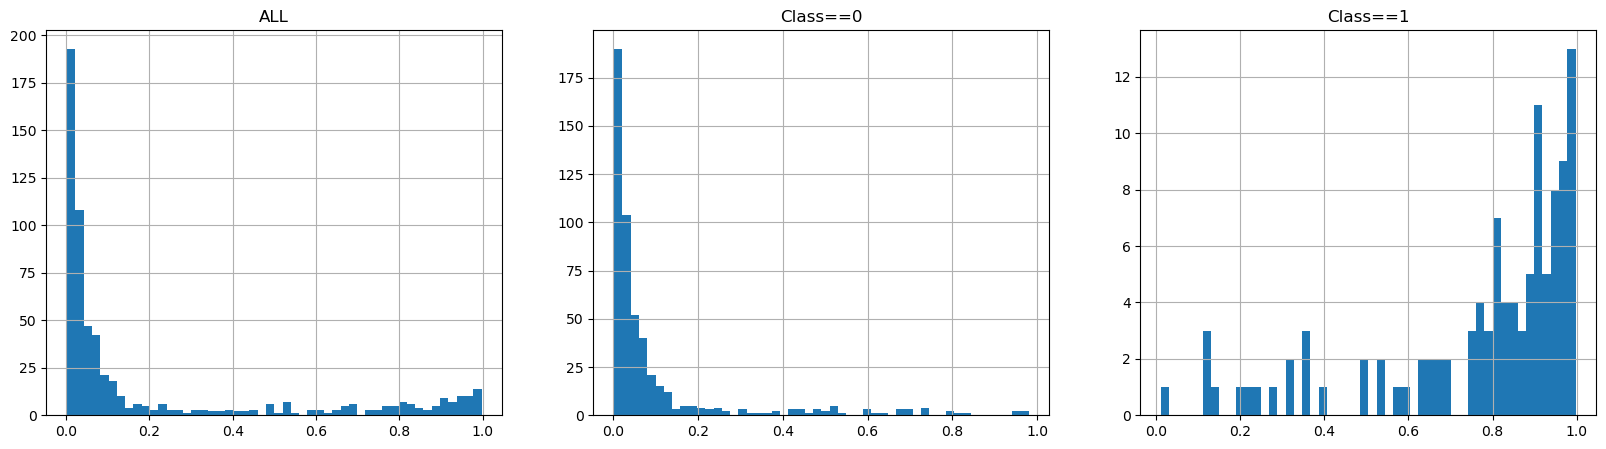

CV repeat nbr: 1 - metric: 0.2236


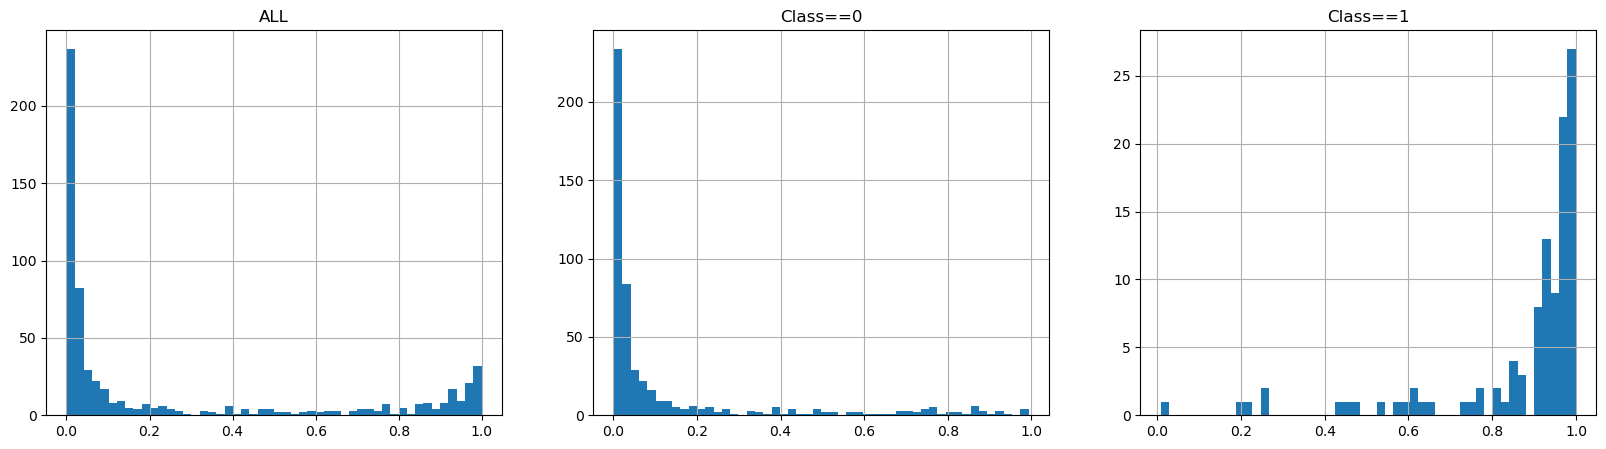

####################################################################################################
CV repeat nbr: 2 - metric: 0.2740


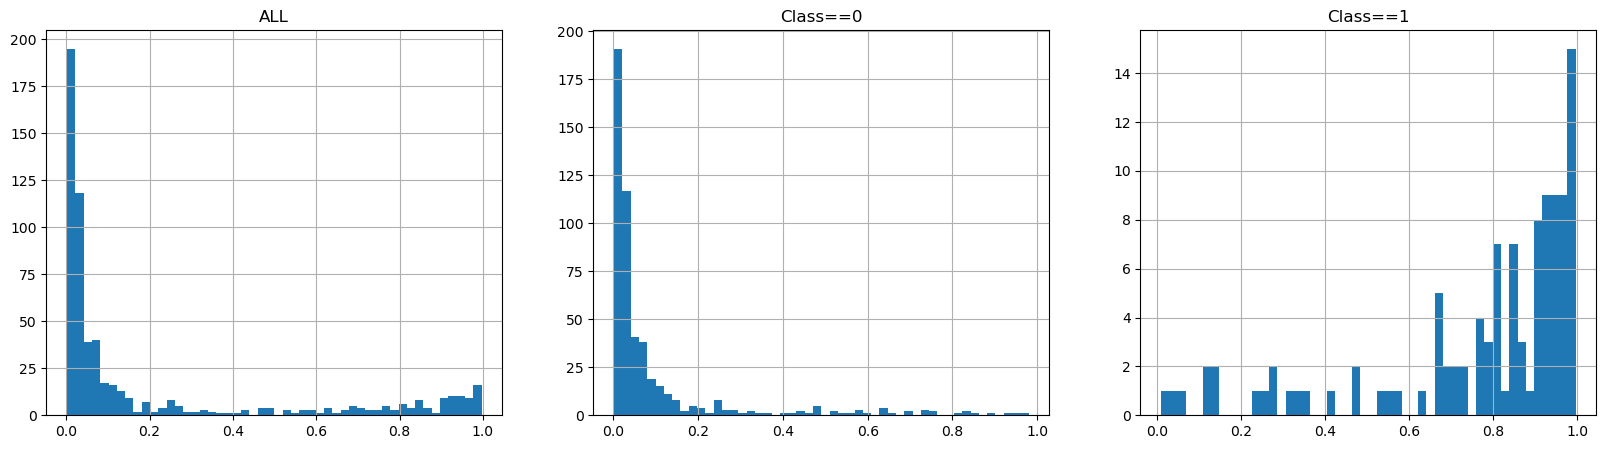

CV repeat nbr: 2 - metric: 0.2434


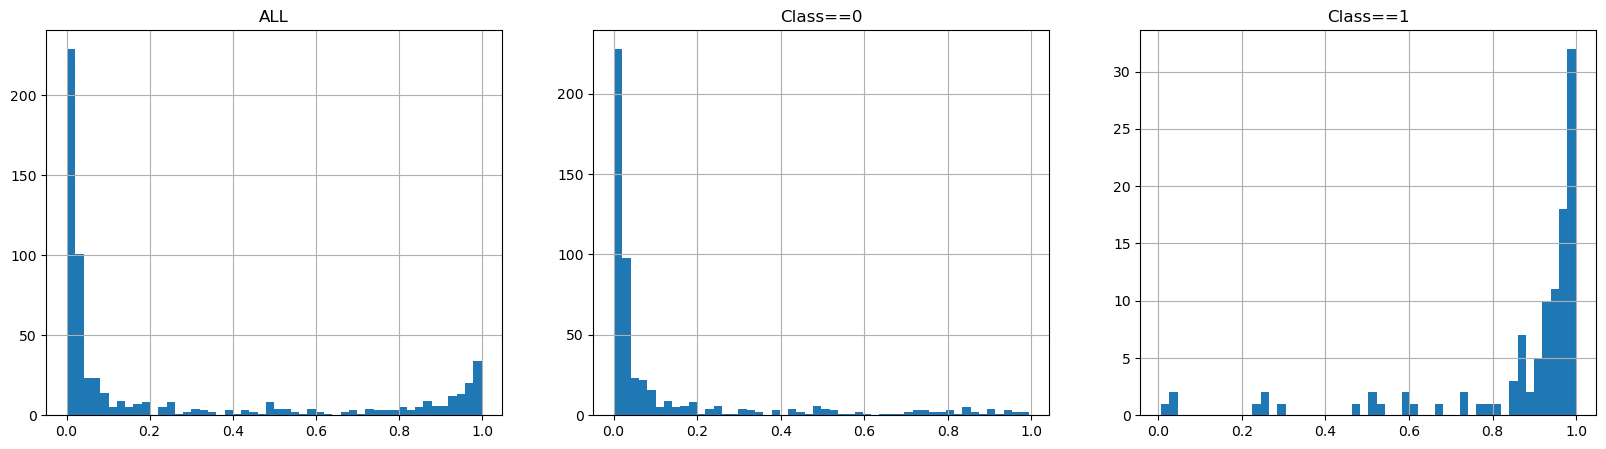

####################################################################################################
CV repeat nbr: 3 - metric: 0.2526


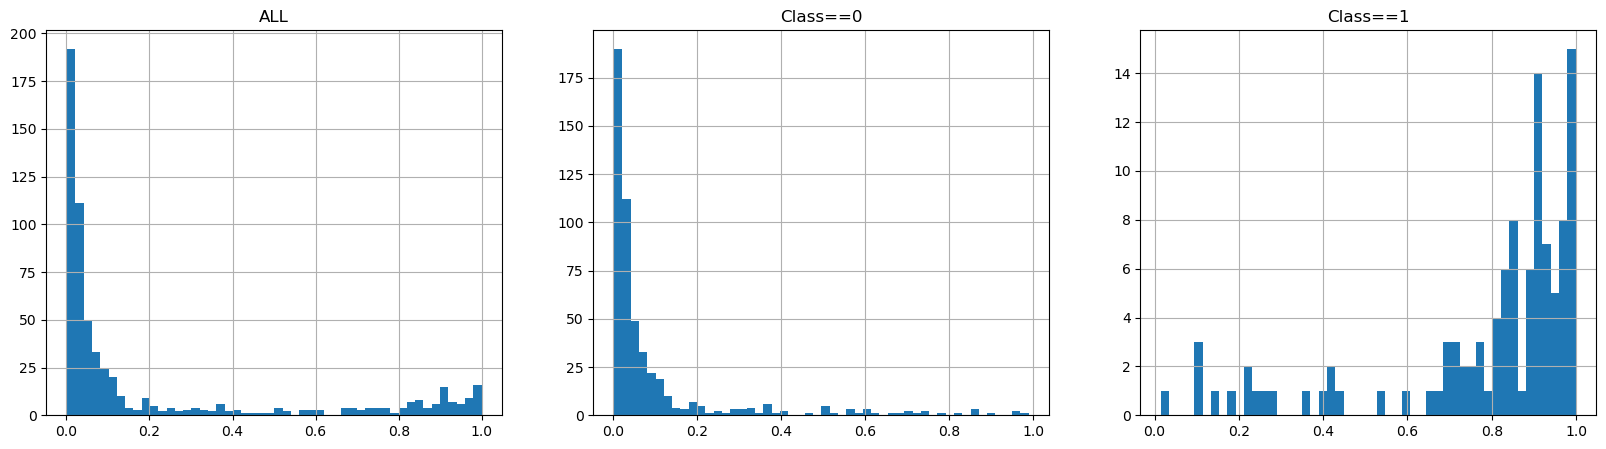

CV repeat nbr: 3 - metric: 0.2206


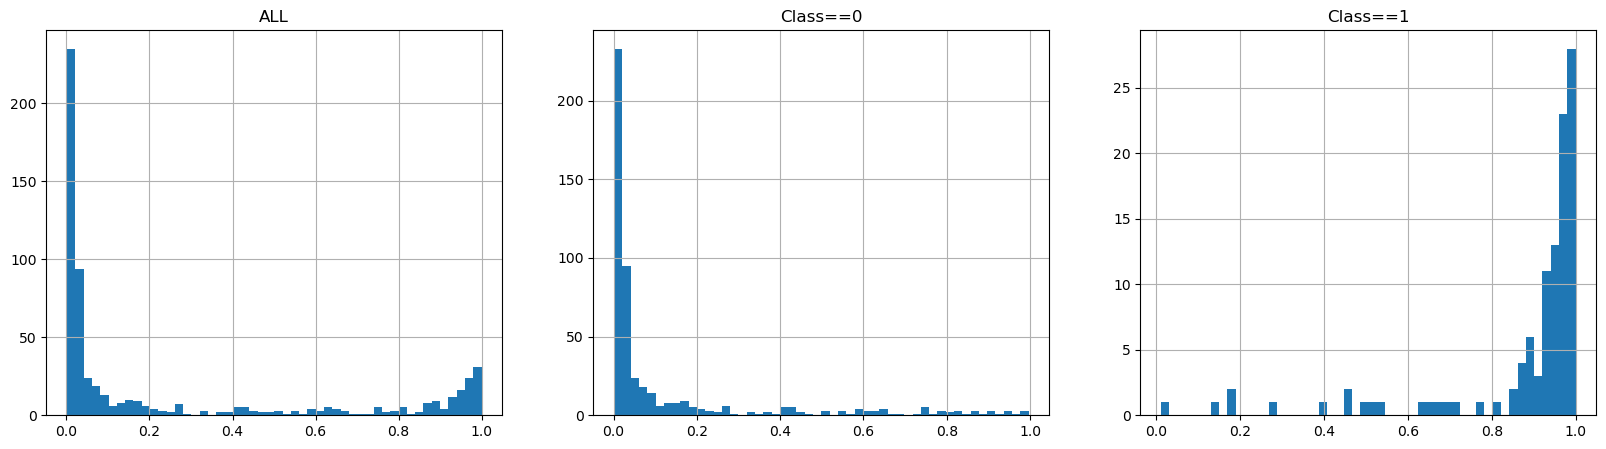

####################################################################################################
CV repeat nbr: 4 - metric: 0.2620


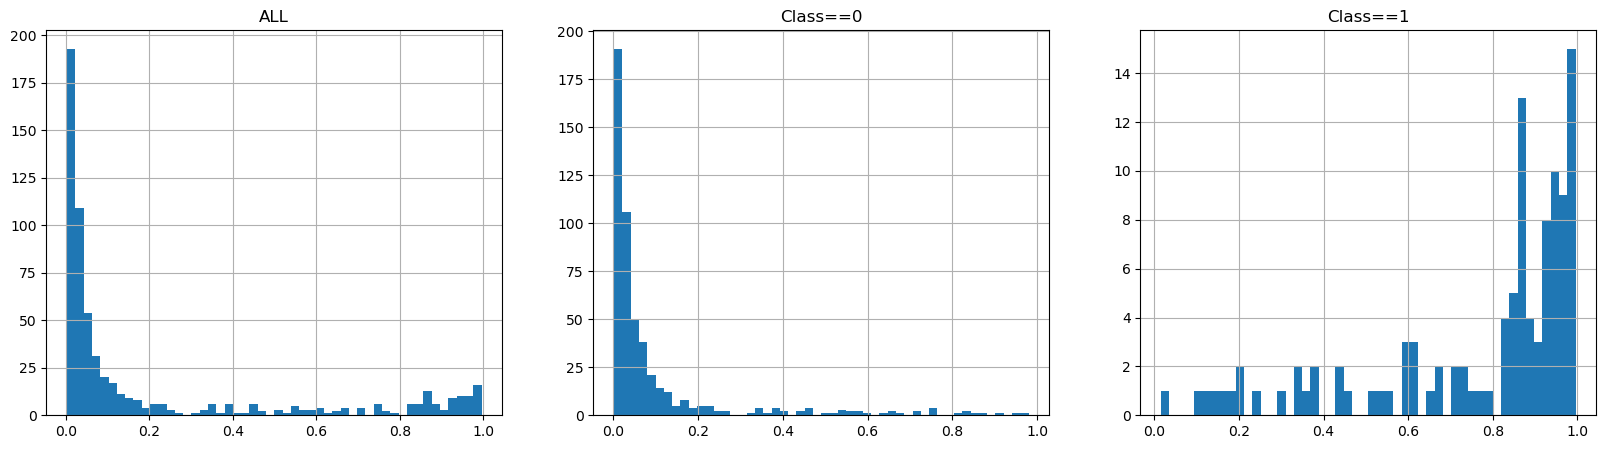

CV repeat nbr: 4 - metric: 0.2205


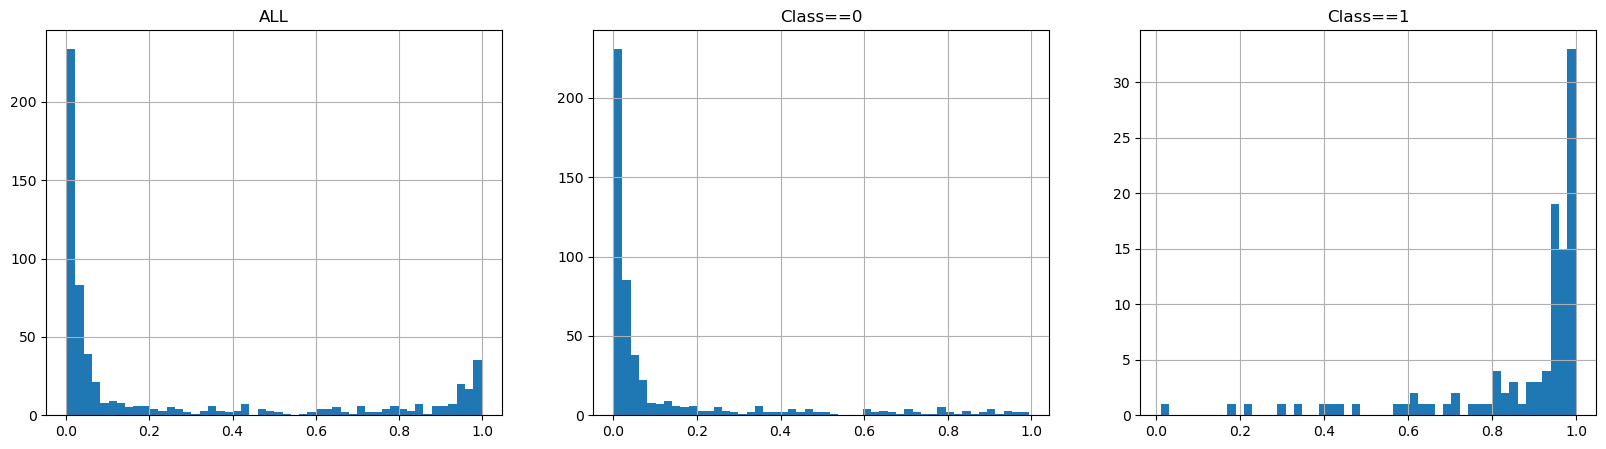

####################################################################################################
CV repeat nbr: 5 - metric: 0.2700


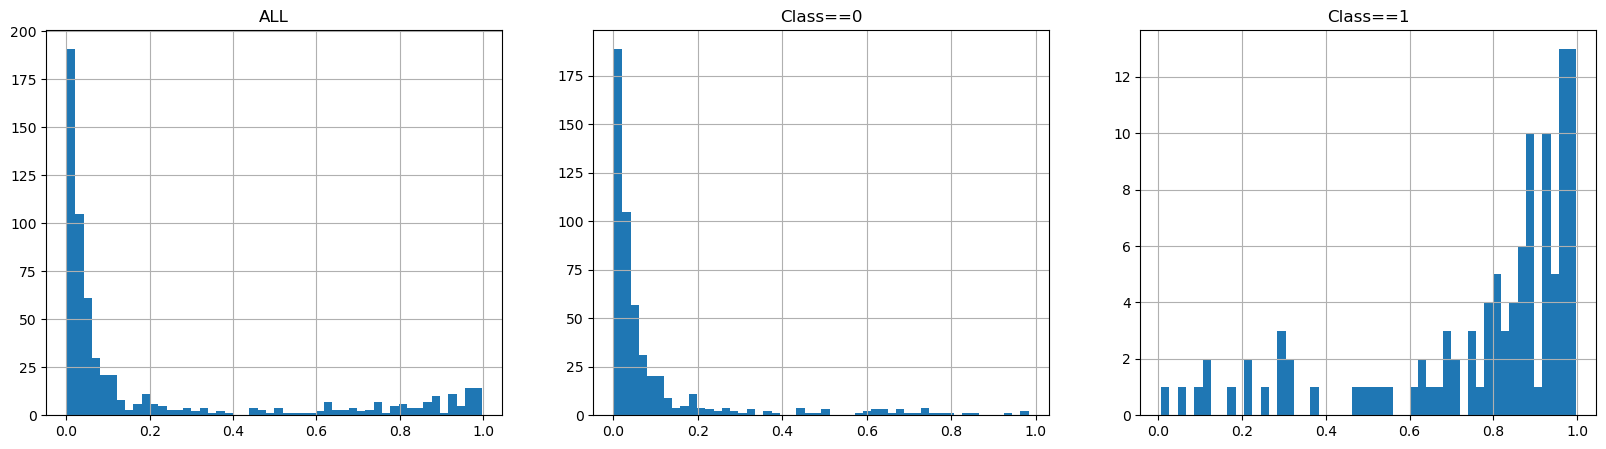

CV repeat nbr: 5 - metric: 0.2346


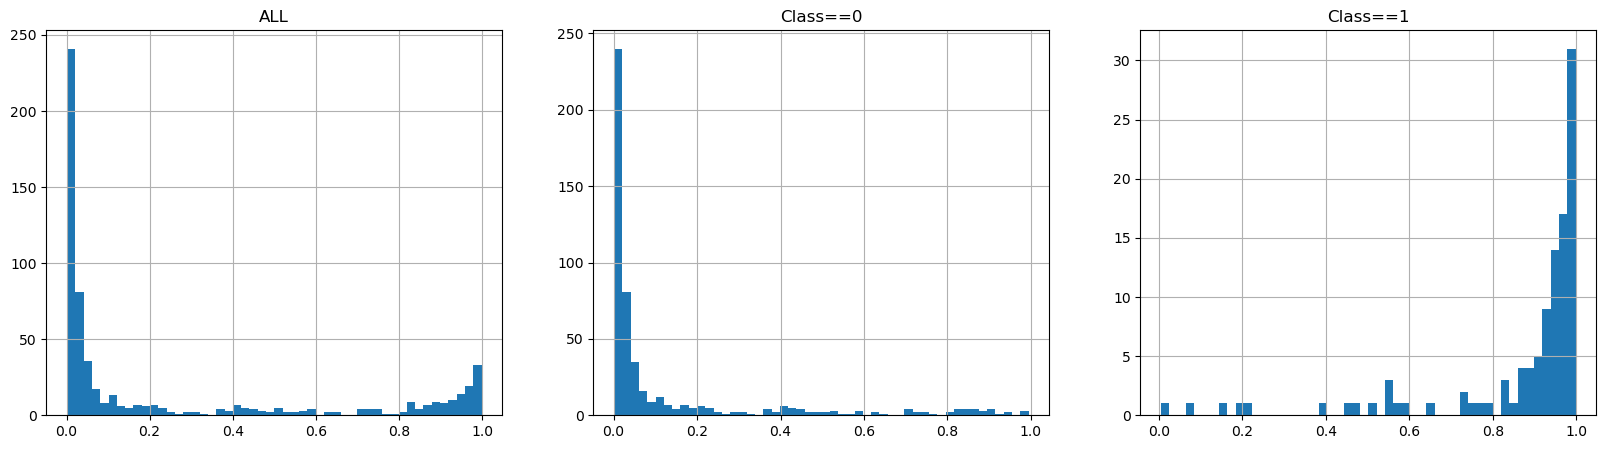

####################################################################################################
CV repeat nbr: 6 - metric: 0.2636


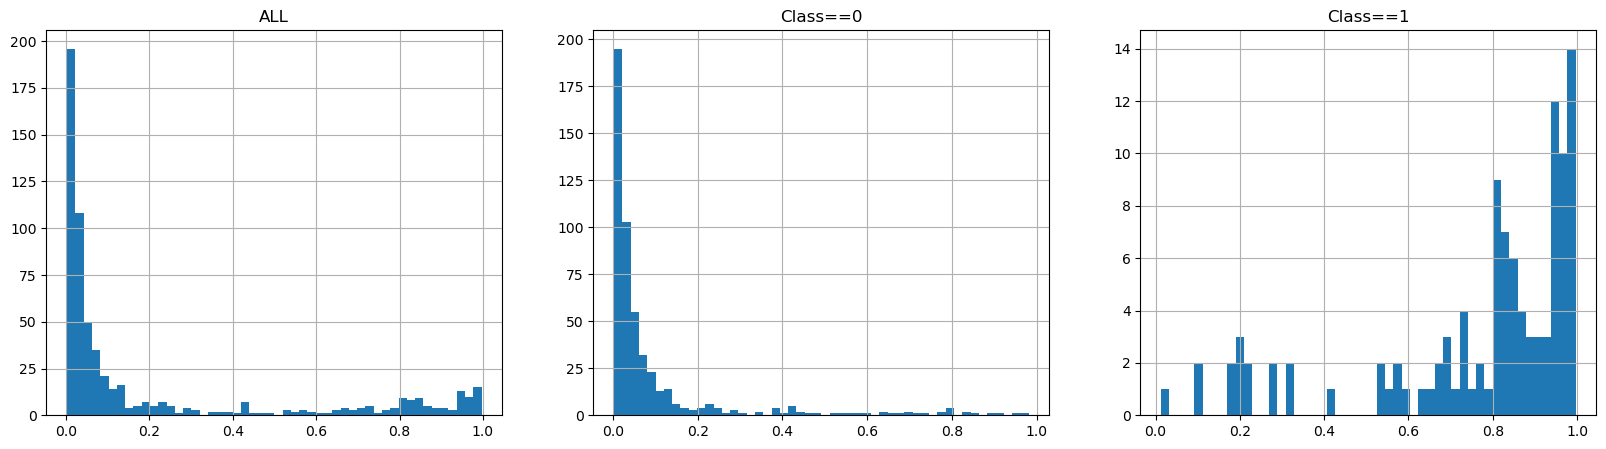

CV repeat nbr: 6 - metric: 0.2225


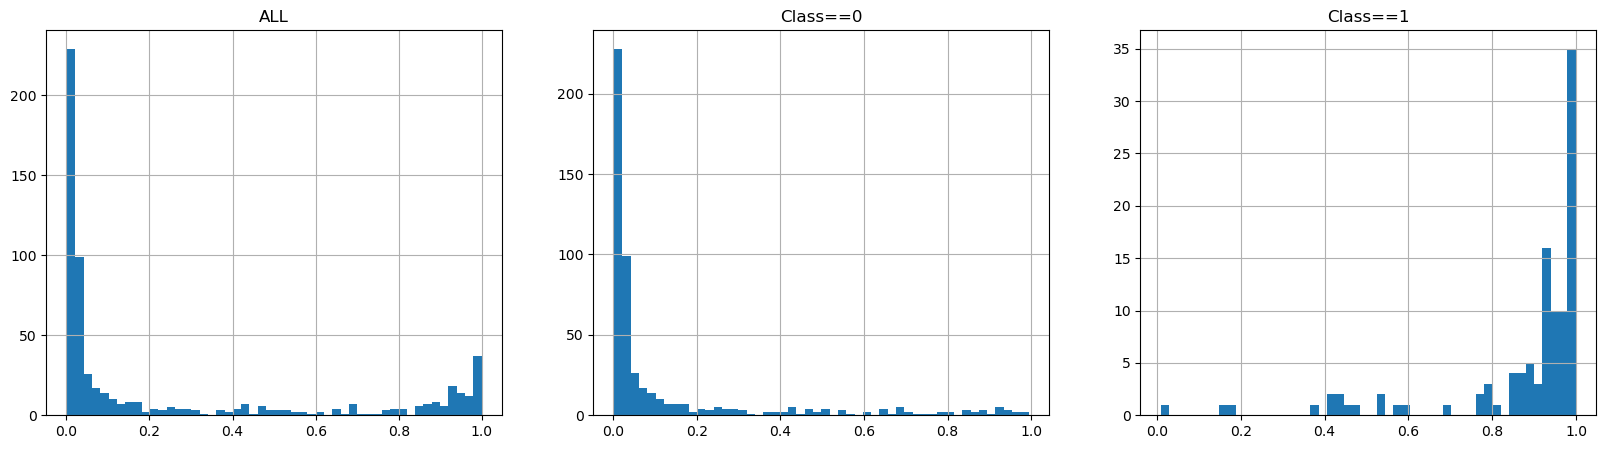

####################################################################################################
CV repeat nbr: 7 - metric: 0.2629


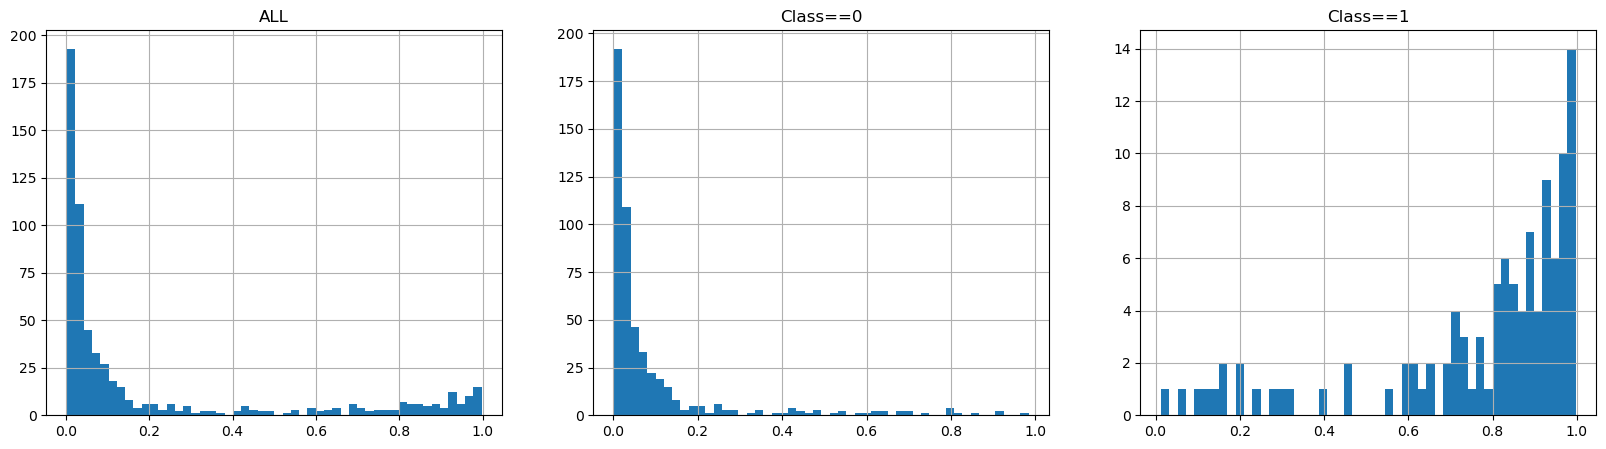

CV repeat nbr: 7 - metric: 0.2253


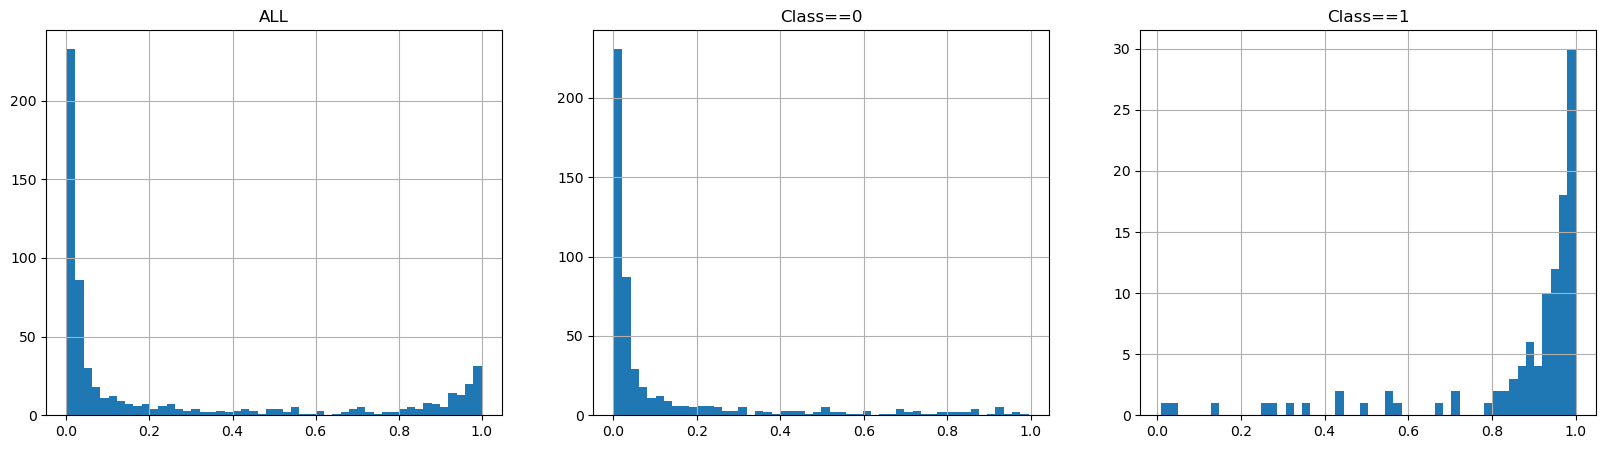

####################################################################################################
CV repeat nbr: 8 - metric: 0.2695


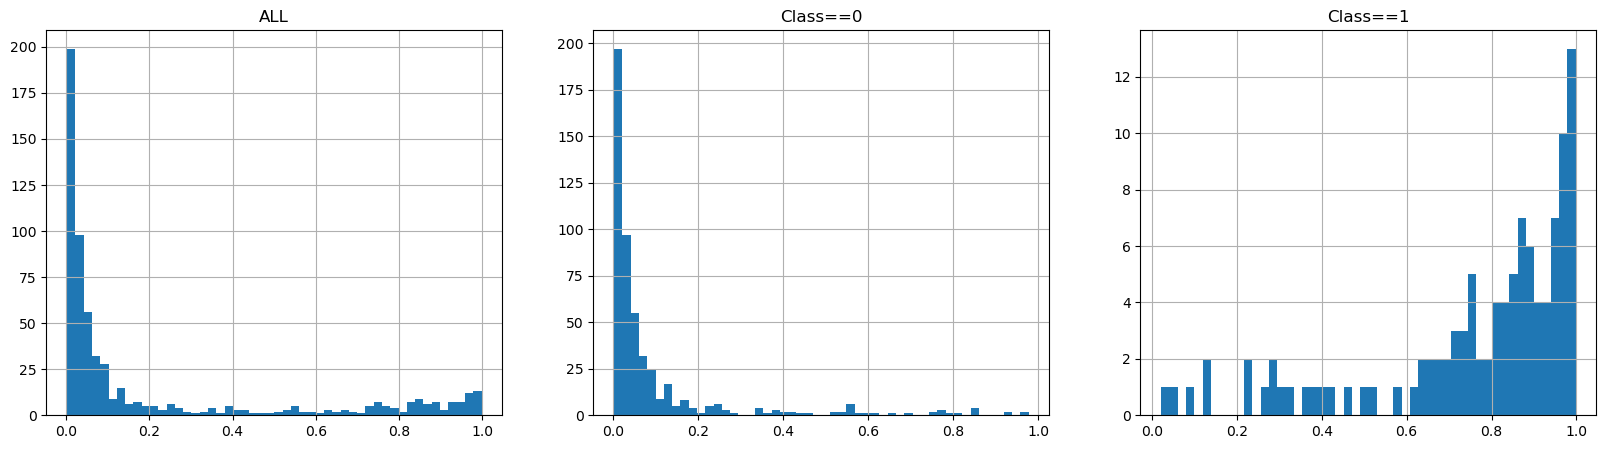

CV repeat nbr: 8 - metric: 0.2321


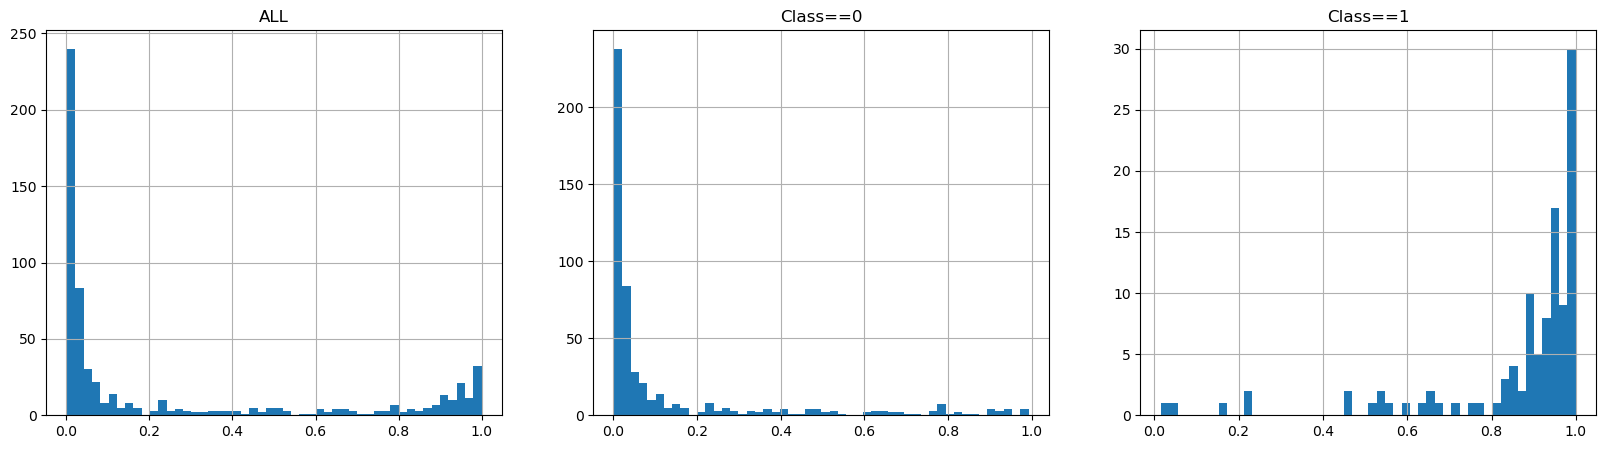

####################################################################################################
CV repeat nbr: 9 - metric: 0.2489


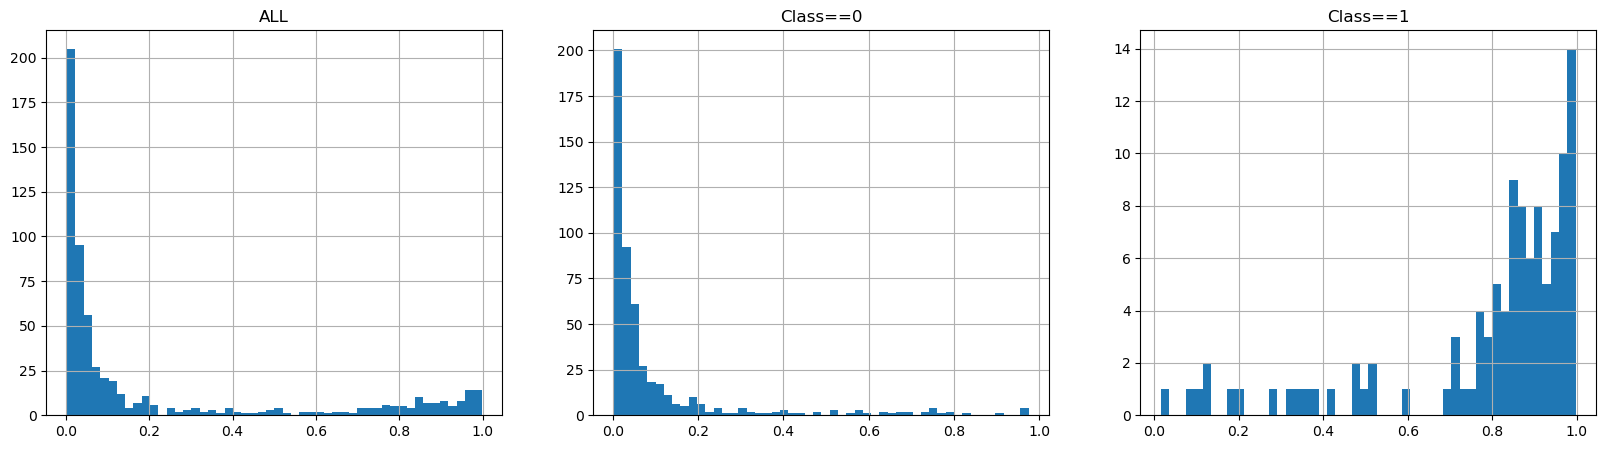

CV repeat nbr: 9 - metric: 0.2234


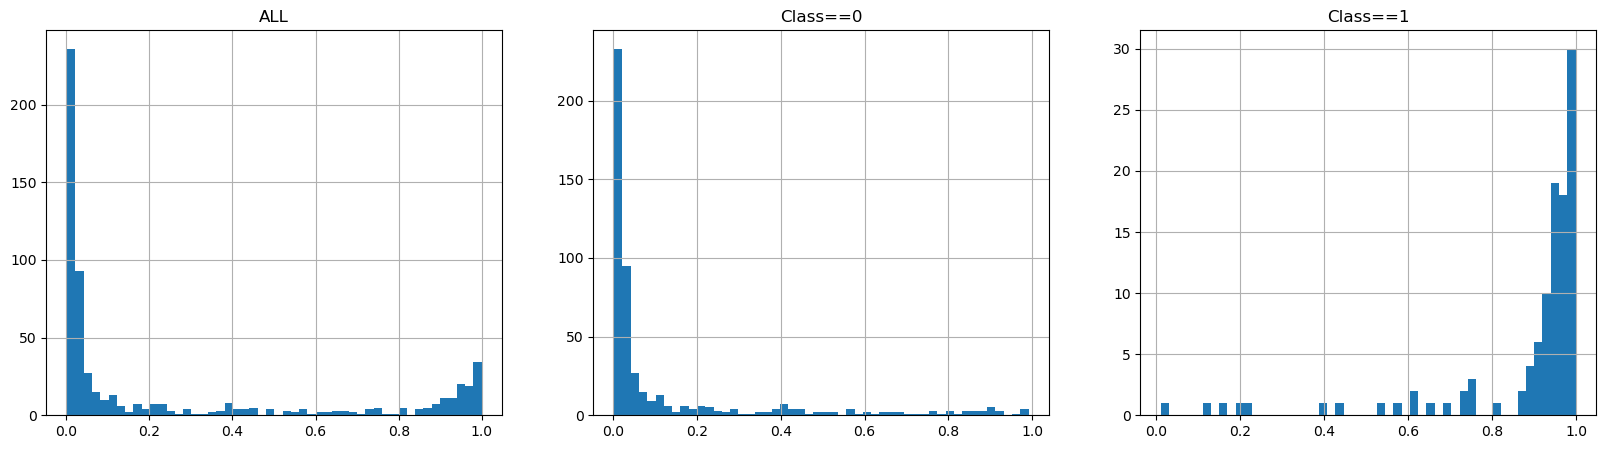

####################################################################################################
CV repeat nbr: 10 - metric: 0.2684


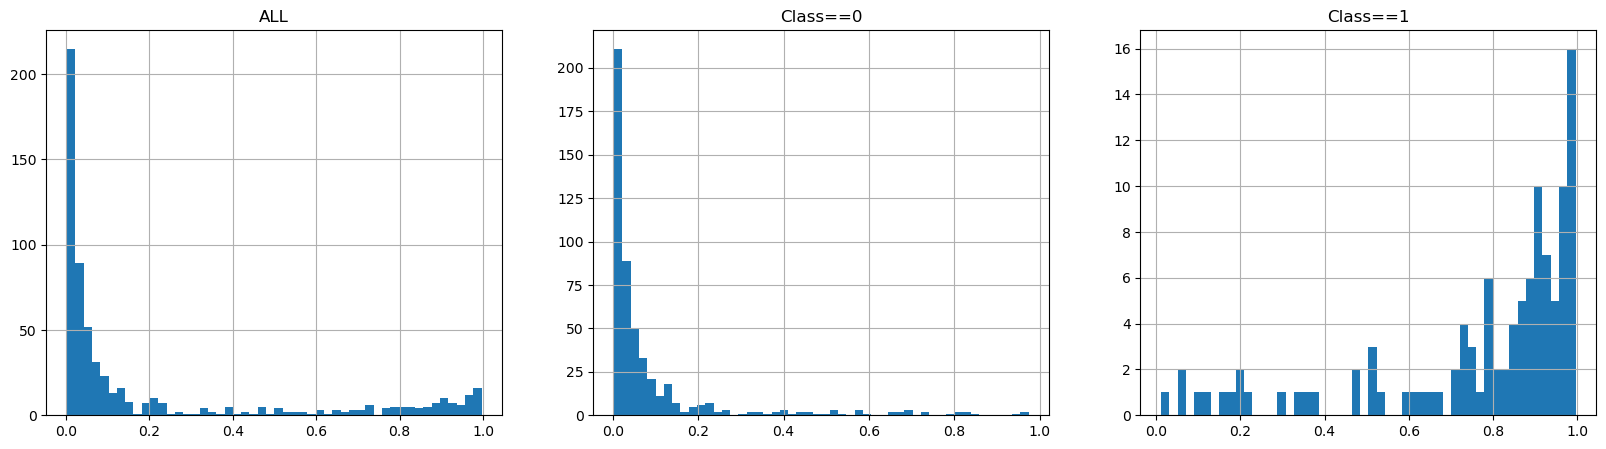

CV repeat nbr: 10 - metric: 0.2374


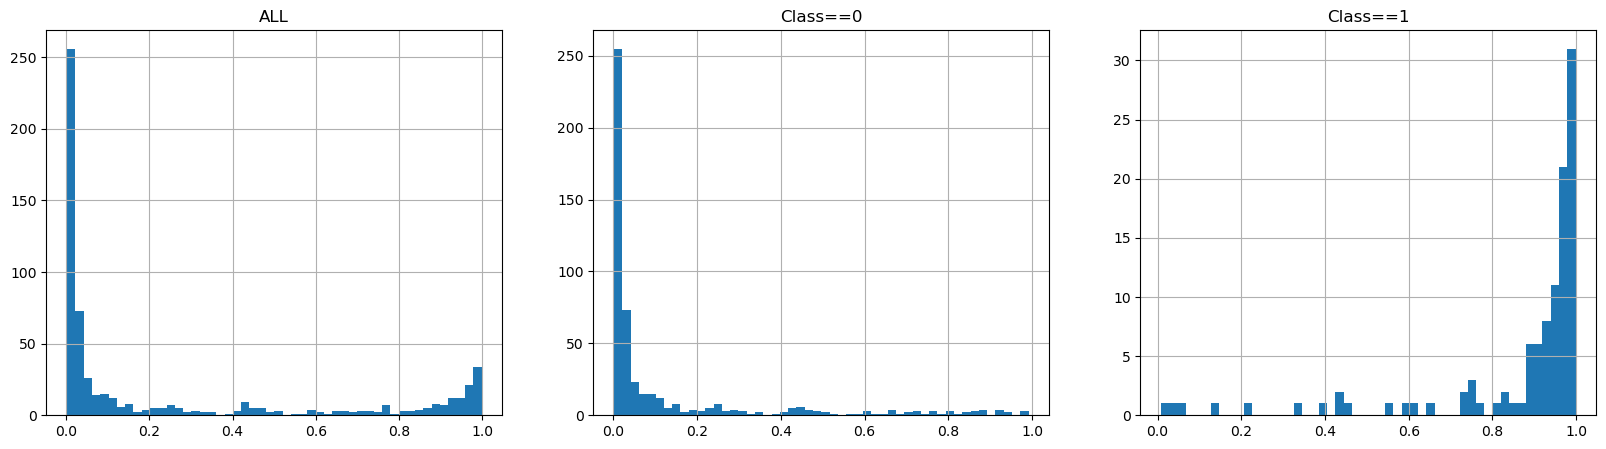

In [11]:
for i,oof in enumerate(oof_dfs):
    print("#"*100)
    oof = oof.copy()
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()
    
    calib_p1 = calibrate_probs(
        oof.pred_proba.values,
        **calib_params
    )
    oof["pred_proba"] = calib_p1
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()

***
# inference

In [12]:
predicted_probs = [
    model.predict(test[input_cols], prediction_type="Probability")[:,1]
    for model in models
]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.48414607, 0.48414607, 0.48414607, 0.48414607, 0.48414607])

In [13]:
predicted_probs = calibrate_probs(predicted_probs, **calib_params)
predicted_probs = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)
predicted_probs

array([0.73714156, 0.73714156, 0.73714156, 0.73714156, 0.73714156])

In [14]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.to_csv("submission.csv", index=False)
sub.describe()

,class_0,class_1
count,5.000000,5.000000
mean,0.262858,0.737142
std,0.000000,0.000000
min,0.262858,0.737142
25%,0.262858,0.737142
50%,0.262858,0.737142
75%,0.262858,0.737142
max,0.262858,0.737142


***
## save artifacts

In [15]:
joblib.dump(models, "models.pkl")
joblib.dump(oof_dfs, "oof_dataframes.pkl")
oof_scores.to_csv("oof_scores.csv", index=False)
joblib.dump(calib_params, "calib_params.pkl")

['calib_params.pkl']

***